In [1]:
#%% Imports
import os
import numpy as np
import spectral
import matplotlib.pyplot as plt
from skimage import exposure, io
import json

In [95]:
#%% Paths
# If the dataset has the same structure as on Box, only base_data_dir needs to be changed
data_dir = '/media/mha114/MassimalDataProcessing/202105_Skjerstad/Hyperspectral/SandsundTransects/R_rs/T1'
trans1_rrs_file = os.path.join(data_dir,'manual_Pika_L_1-radiance-Crop Wavelengths.bip.hdr')

outfile = os.path.join(data_dir,'test_noglint.hdr')

In [22]:
#%% Constants / input parameters
rbg_default = (640, 550, 460)   # Default wavelengths for RGB display
nir_band = (780,840)

In [80]:
def pct_contrast_stretch(im, rgb_index, pct_range=(2,98),stretch_bands_separately = True):
    im_rgb = im[:,:,rgb_index]
    
    if stretch_bands_separately:
        im_rgb_stretch = np.zeros(im_rgb.shape)
        im_rgb = np.moveaxis(im_rgb,-1,0)
        for band_num, im_band in enumerate(im_rgb):
            p_low,p_high = np.percentile(im_band, pct_range)
            im_rgb_stretch[:,:,band_num] = exposure.rescale_intensity(im_band, in_range=(p_low, p_high))
    else:
        p_low,p_high = np.percentile(im_rgb, pct_range)
        im_rgb_stretch = exposure.rescale_intensity( im_rgb, in_range=(p_low,p_high))
    return im_rgb_stretch
    

In [4]:
#%% Open and load image
im_handle = spectral.io.envi.open(trans1_rrs_file) 
im = np.array(im_handle.load())

In [9]:
#%% Convert relevant metadata
# Read wavelengths
wl = np.array([float(i) for i in im_handle.metadata['wavelength']])

# Get indices for standard RGB render
rgb_ind = tuple((np.abs(wl - value)).argmin() for value in rbg_default)

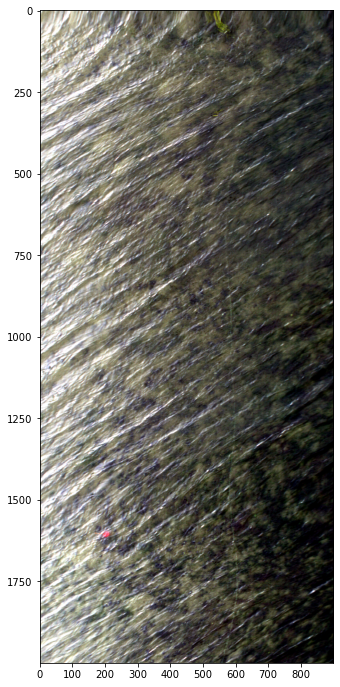

In [84]:
#%% Show contrast stretched original image 
fig,ax = plt.subplots(figsize=(6,12))
plt.imshow(pct_contrast_stretch(im, rgb_ind))

In [90]:
#%% Estimate and subtract glint from each pixel
nir_ind = (wl > nir_band[0]) & (wl < nir_band[1])

mean_nir = np.mean(im[:,:,nir_ind], axis=2)
mean_nir = np.expand_dims(mean_nir, axis=2)

im_noglint = im - mean_nir

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


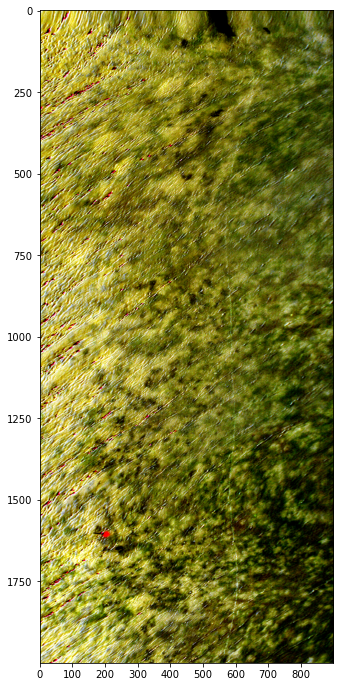

In [82]:
#%% Show image with glint removed
fig,ax = plt.subplots(figsize=(6,12))
plt.imshow(pct_contrast_stretch(im_noglint, rgb_ind))

In [96]:
spectral.io.envi.save_image(outfile,im_noglint)